In [1]:
import pickle
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")


from sklearn.svm import LinearSVR
from xgboost import XGBRegressor
from collections import namedtuple
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error

In [2]:
data = pd.read_csv('../data/processed_dataset.csv')

In [3]:
data = data[['budget','runtime','has_collection', 'Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History',
       'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie',
       'Thriller', 'War', 'Western', 'is_english', 'number_of_languages', 'number_of_keywords', 'cast_size', 'crew_size',
       'has_homepage', 'budget_log', 'popularity_log','revenue']]

We don't want to penalize huge differences in the predicted and revenue when both predicted and revenues are huge numbers. That's why we convert revenue into logarithamic form.

In [4]:
data['revenue'] = np.log1p(data.revenue)

In [82]:
class Regressor:
    def __init__(self,estimator, parameters,data, cv=3, n_jobs=1, grid_search=True):
        self.cv = cv
        self.n_jobs = n_jobs
        self.estimator = estimator
        self.parameters = parameters
        self.grid_search = grid_search
        self.x_test = data.x_test
        self.y_test = data.y_test
        self.x_train = data.x_train
        self.y_train = data.y_train

        if self.grid_search:
            self._estimator = GridSearchCV(self.estimator(), self.parameters, cv=self.cv, n_jobs=self.n_jobs)
        else:
            self._estimator = self.estimator(**self.parameters)
        self._estimator = self.__fit_model()
            
    def __repr__(self):
        return f"Regressor"
    
    def __fit_model(self):
        self._estimator.fit(self.x_train, self.y_train)
        return self._estimator
    
    @property
    def scores(self):
        train_score = self.score(self.y_train, self._estimator.predict(self.x_train))
        test_score = self.score(self.y_test, self._estimator.predict(self.x_test))
        return {'train_score':train_score, 'test_score': test_score}
        
    def predict(self, x_test):
        pred_value = self._estimator.predict(x_test)
        return pred_value
    
    def score(self, y_true, y_pred):
        _score = mean_squared_error(y_true, y_pred)
        return  _score
    
    
def train_test_features(data, columns = None, target_value='revenue'):
    if columns == None:
        columns = [i for i in data.columns if i != target_value]
    return data[columns], data[[target_value]]

def train_test_spliter(data, features = None, target_value = 'revenue',ratio =0.20):
    train_test_data = namedtuple('train_test_data', ['x_train','x_test','y_train','y_test'])
    vectors , label = train_test_features(data, features, target_value)
    x_train, x_test, y_train, y_test = train_test_split(vectors,label,test_size= ratio)
    return train_test_data(x_train, x_test, y_train, y_test)

def run_regression_experiments(config_values, data, n_jobs=1, cv=3, 
                               features = None, target_value='revenue', ratio=0.20):

    dataset = train_test_spliter(data, features, target_value, ratio)
    models = []
    est_scores = []
    for config in config_values:
        model = config['estimator']
        params = config['estimator_configs']
        grid_search = config['grid_search']
        estimator = Regressor(model, parameters=params, data=dataset, cv=cv, n_jobs=n_jobs,grid_search= grid_search)
        score = estimator.scores
        score['estimator'] = model.__name__
        print(f"Estimator: {model.__name__} & Test score: {score.get('test_score')}")
        model = estimator._estimator
        models.append((model, score.get('test_score')))
        est_scores.append(score)
    return pd.DataFrame(est_scores), models

In [6]:
config = [
        # LinearRegression
        {'estimator':LinearRegression,
            'estimator_configs':{},
          'grid_search':False},
        
        # DecisionTreeRegressor 
        {'estimator':DecisionTreeRegressor,
         'estimator_configs': {'max_features': ['auto'], 
                               'max_depth': [ 3, 5, 7, 10], 'min_samples_split': [2, 5, 10, 0.1], 
                               'min_samples_leaf': [2], 'criterion': ['mse', 'mae']},
         'grid_search': True},
    
        # ExtraTreesRegressor
        {'estimator':ExtraTreesRegressor,
         'estimator_configs': {'n_estimators': [2, 10, 25, 100], 'max_features': ['auto'], 
                               'max_depth':[ 3, 5, 7], 'min_samples_split': [2, 5, 10], 
                               'min_samples_leaf': [2], 'criterion': ['mse', 'mae']},
         'grid_search': True},
    
        # RandomForestRegressor
        {'estimator': RandomForestRegressor,
         'estimator_configs': {'n_estimators':[10,20,30,40,50], 'max_depth':[2,3,4,5],
                                'min_samples_split':[4,5,9,10]},
         'grid_search':True},
        
        # XGBRegressor
         {'estimator': XGBRegressor ,
          'estimator_configs':{'max_depth' : [2,3,5], 'learning_rate' : [0.1,0.15,0.20,0.25],
                              'n_estimators':[10,20,30,40,50]} ,
          'grid_search' : True},
        #LinearSVR
        {'estimator':LinearSVR,
         'estimator_configs': {'C': [ 0.1, 1, 5], 'epsilon': [1e-3, 1e-2, 0.1, 0], 'tol': [1e-4, 1e-3, 1e-2], 'max_iter': [100, 200],
                               'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'],
                               'intercept_scaling': [0.1, 0.5, 1, 5, 10] },
         'grid_search': True},
        
        # MLPRegressor
        {'estimator':MLPRegressor,
         'estimator_configs': { 'hidden_layer_sizes': [(64,), (32, 64)], 'activation': ['identity', 'tanh', 'relu'], 
                          'max_iter': [500],'early_stopping': [True], 'learning_rate': ['invscaling', 'adaptive']},
         'grid_search':True }
         ]


### Baseline Model

In [7]:
import matplotlib
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.model_selection import FeatureImportances

FeatureImportances(absolute=False,
          ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fe182575f60>,
          colormap=None, colors=None, is_fitted='auto', labels=None,
          model=None, relative=False, stack=False, xlabel=None)

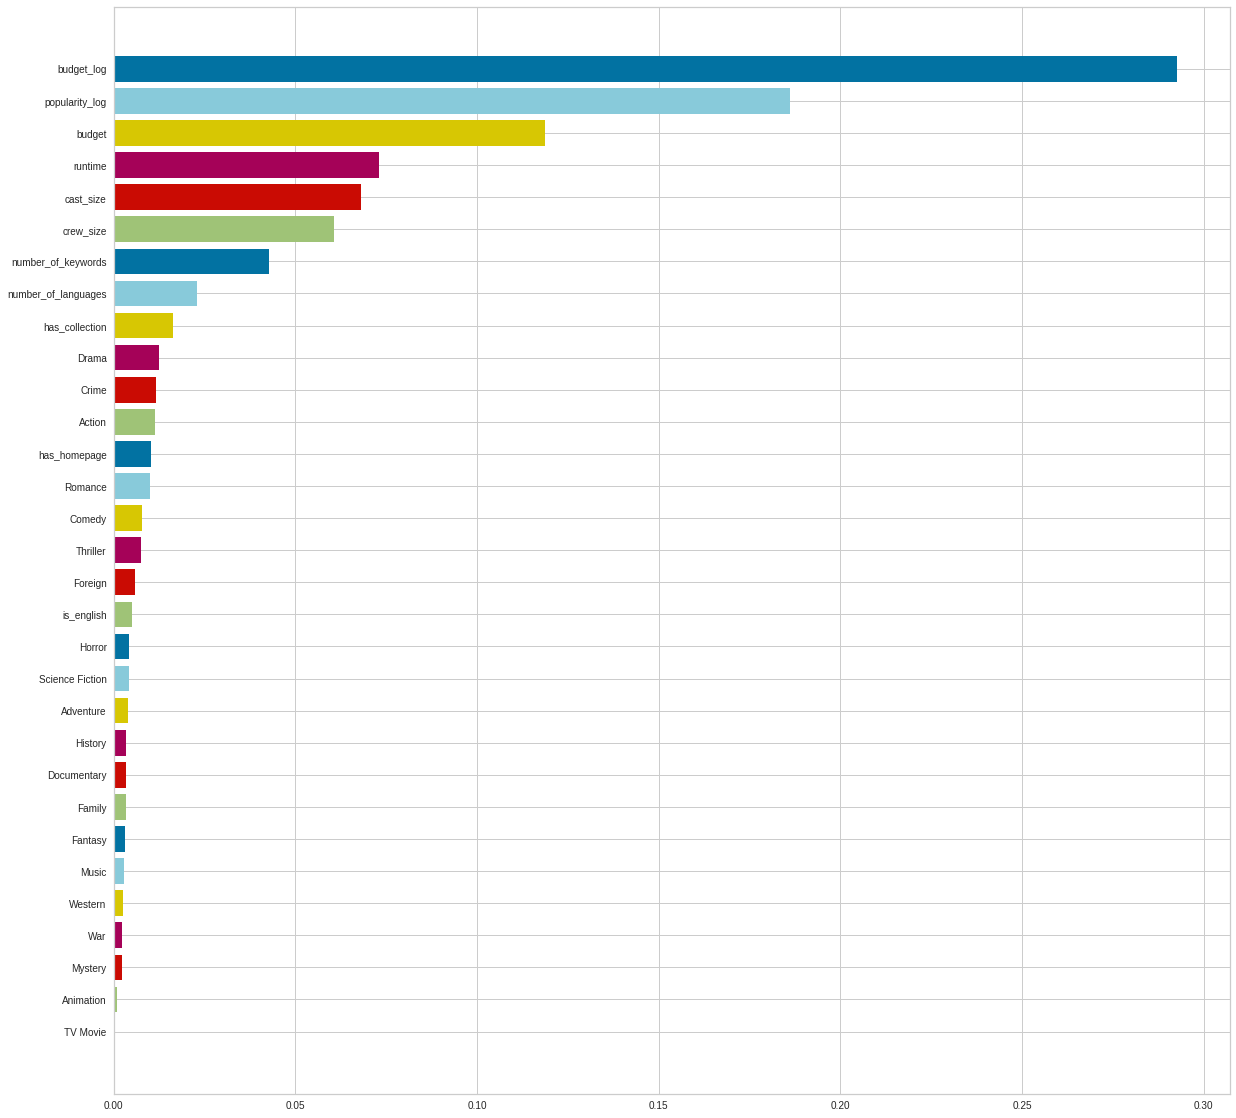

In [9]:
viz = FeatureImportances(RandomForestRegressor(), labels=list(data.columns).remove('revenue'), relative=False)
dataset = train_test_spliter(data)
matplotlib.rc('figure',figsize=(20,20))
viz.fit(dataset.x_train, dataset.y_train)

from the above feature importance plot we can observe that the most important features that are lifting the model are budget, popularity, runtime, crew size and cast size and number of keywords so in our further models we will be using these features to build our baseline models. provided we have more time we can use other techniques like forward selection/backward elimination and select the optimal features for the model.

In [10]:
from yellowbrick.regressor import PredictionError, ResidualsPlot

In [11]:
dataset = train_test_spliter(data,features=['budget','popularity_log','budget_log','cast_size','crew_size',
                                            'runtime','number_of_keywords','has_collection','has_homepage'])

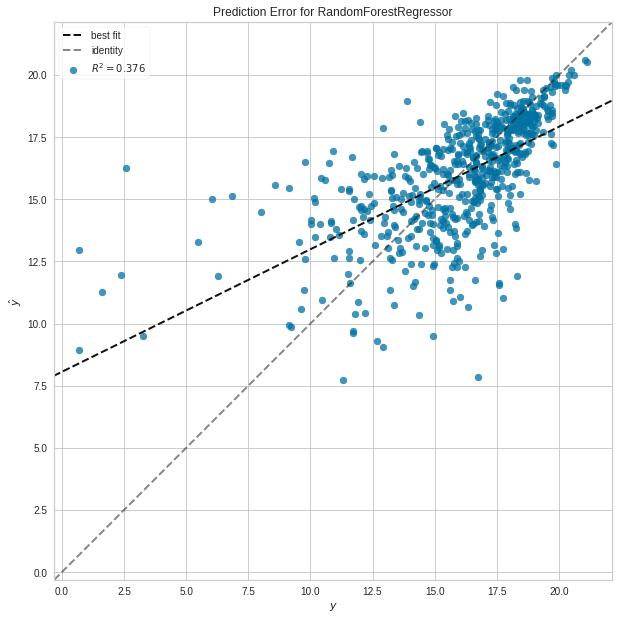

In [14]:
matplotlib.rc('figure',figsize=(10,20))
model = RandomForestRegressor()
visualizer = PredictionError(model)
visualizer.fit(dataset.x_train, dataset.y_train)# Fit the training data to the visualizer
visualizer.score(dataset.x_test, np.array(dataset.y_test.values))  # Evaluate the model on the test data
visualizer.poof()  

In [15]:
analysis, best_model = run_regression_experiments(config_values=config, data = data,features= ['budget','popularity_log','budget_log','cast_size','crew_size',
                                                                                   'runtime','number_of_keywords','has_collection','has_homepage'])

Estimator: LinearRegression & Test score: 5.173706265988755
Estimator: DecisionTreeRegressor & Test score: 5.066060947343128
Estimator: ExtraTreesRegressor & Test score: 4.6531113869819265
Estimator: RandomForestRegressor & Test score: 4.931960012768033
Estimator: XGBRegressor & Test score: 4.894589338624393
Estimator: LinearSVR & Test score: 22060.815729946986
Estimator: MLPRegressor & Test score: 7.495650598090821


In [16]:
analysis

,estimator,test_score,train_score
0,LinearRegression,5.173706,5.295297
1,DecisionTreeRegressor,5.066061,5.030265
2,ExtraTreesRegressor,4.653111,3.954136
3,RandomForestRegressor,4.931960,4.285078
4,XGBRegressor,4.894589,4.641661
5,LinearSVR,22060.815730,24405.627533
6,MLPRegressor,7.495651,7.302857


Look likes random forest and XGBoost are pretty decent compare to the other models.

in our dataset we observe that some of the budget values are 0, maybe they are bad data. so lets remove those and see how the model performs.

In [50]:
updated_data = data[data['budget'] > 50]

In [56]:
updated_dataset = train_test_spliter(updated_data,features=['budget','popularity_log','budget_log','cast_size',
                                                                                                    'crew_size','runtime','number_of_keywords',
                                                                                                    'has_collection','has_homepage', 
                                                                                                    'number_of_languages'])

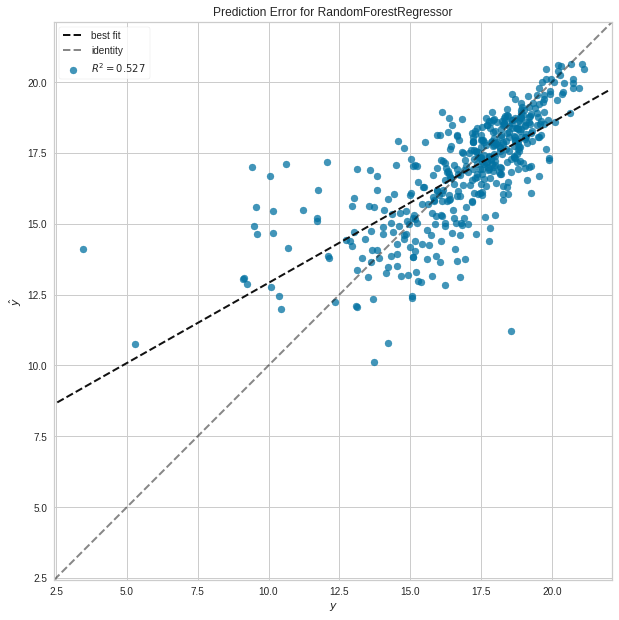

In [57]:
model = RandomForestRegressor()
visualizer = PredictionError(model)
visualizer.fit(updated_dataset.x_train, updated_dataset.y_train)# Fit the training data to the visualizer
visualizer.score(updated_dataset.x_test, np.array(updated_dataset.y_test.values))  # Evaluate the model on the test data
visualizer.poof()  

In [88]:
updated_analysis, best_model = run_regression_experiments(config_values=config, data = updated_data, features= ['budget','popularity_log','budget_log','cast_size',
                                                                                                    'crew_size','runtime','number_of_keywords',
                                                                                                    'has_collection','has_homepage', 
                                                                                                    'number_of_languages'])

Estimator: LinearRegression & Test score: 2.319125637734467
Estimator: DecisionTreeRegressor & Test score: 2.5381641088001685
Estimator: ExtraTreesRegressor & Test score: 2.248954054113636
Estimator: RandomForestRegressor & Test score: 2.2826628956302635
Estimator: XGBRegressor & Test score: 2.299194297986919
Estimator: LinearSVR & Test score: 1426.3751601139961
Estimator: MLPRegressor & Test score: 4.752432914570524


In [89]:
updated_analysis

,estimator,test_score,train_score
0,LinearRegression,2.319126,3.218626
1,DecisionTreeRegressor,2.538164,3.110614
2,ExtraTreesRegressor,2.248954,2.493051
3,RandomForestRegressor,2.282663,2.531979
4,XGBRegressor,2.299194,2.731217
5,LinearSVR,1426.375160,1378.703886
6,MLPRegressor,4.752433,6.289482


### save the best model

In [94]:
best_model = sorted(best_model,key=lambda x: x[1])[0][0]

In [96]:
def save_model(path, model):
    with open(path,'wb') as f:
        pickle.dump(model, f)

In [98]:
save_model('../model/best_model.pkl',best_model)